In [118]:
import os
import sys

# Allow imports from src folder
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import betfairlightweight
from betfairlightweight import filters
from datetime import datetime, timedelta
from dateutil import tz
from pandas.tseries.offsets import MonthEnd

import math
import numpy as np
import pandas as pd
import fasttrack as ft

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

from matplotlib import pyplot
from matplotlib.pyplot import figure

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Validate FastTrack API connection
client = ft.Fasttrack(os.getenv('FAST_TRACK_API_KEY'))
track_codes = client.listTracks()

Valid Security Key


In [3]:
# Import AU races data
au_tracks_filter = list(track_codes[track_codes['state'] != 'NZ']['track_code'])

race_details = pd.DataFrame()
dog_results = pd.DataFrame()

for start in pd.date_range('2017-12-01', '2021-07-31', freq='MS'):
    start_date = start.strftime("%Y-%m-%d")
    end_date = (start + MonthEnd(1)).strftime("%Y-%m-%d")
    filename_races = f'FT_AU_RACES_{start_date}.csv'
    filename_dogs = f'FT_AU_DOGS_{start_date}.csv'
    
    filepath_races = f'../data/{filename_races}'
    filepath_dogs = f'../data/{filename_dogs}'
    
    print(f'Loading data from {start_date} to {end_date}')
    if os.path.isfile(filepath_races):
        # Load local CSV file
        month_race_details = pd.read_csv(filepath_races) 
        month_dog_results = pd.read_csv(filepath_dogs) 
    else:
        # Fetch dta from API
        month_race_details, month_dog_results = client.getRaceResults(start_date, end_date, au_tracks_filter)
        month_race_details.to_csv(filepath_races, index=False)
        month_dog_results.to_csv(filepath_dogs, index=False)

    # Combine monthly data
    race_details = race_details.append(month_race_details, ignore_index=True)
    dog_results = dog_results.append(month_dog_results, ignore_index=True)

display(race_details.head())
display(dog_results.head())

Loading data with from 2017-12-01 to 2017-12-31
Loading data with from 2018-01-01 to 2018-01-31
Loading data with from 2018-02-01 to 2018-02-28
Loading data with from 2018-03-01 to 2018-03-31
Loading data with from 2018-04-01 to 2018-04-30
Loading data with from 2018-05-01 to 2018-05-31
Loading data with from 2018-06-01 to 2018-06-30


/home/bruno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data with from 2018-07-01 to 2018-07-31
Loading data with from 2018-08-01 to 2018-08-31
Loading data with from 2018-09-01 to 2018-09-30
Loading data with from 2018-10-01 to 2018-10-31
Loading data with from 2018-11-01 to 2018-11-30
Loading data with from 2018-12-01 to 2018-12-31
Loading data with from 2019-01-01 to 2019-01-31
Loading data with from 2019-02-01 to 2019-02-28
Loading data with from 2019-03-01 to 2019-03-31
Loading data with from 2019-04-01 to 2019-04-30
Loading data with from 2019-05-01 to 2019-05-31
Loading data with from 2019-06-01 to 2019-06-30
Loading data with from 2019-07-01 to 2019-07-31
Loading data with from 2019-08-01 to 2019-08-31
Loading data with from 2019-09-01 to 2019-09-30
Loading data with from 2019-10-01 to 2019-10-31
Loading data with from 2019-11-01 to 2019-11-30
Loading data with from 2019-12-01 to 2019-12-31
Loading data with from 2020-01-01 to 2020-01-31
Loading data with from 2020-02-01 to 2020-02-29
Loading data with from 2020-03-01 to 202

/home/bruno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading data with from 2021-06-01 to 2021-06-30
Loading data with from 2021-07-01 to 2021-07-31


,@id,RaceNum,RaceName,RaceTime,Distance,RaceGrade,Track,date
0,278896185,1,TRIPLE M BENDIGO 93.5,02:54PM,425m,Grade 6,Bendigo,01 Dec 17
1,278896189,2,GOLDEN CITY CONCRETE PUMPING,03:17PM,500m,Mixed 6/7,Bendigo,01 Dec 17
2,275589809,3,RAILWAY STATION HOTEL FINAL,03:38PM,500m,Mixed 6/7 Final,Bendigo,01 Dec 17
3,278896183,4,MCIVOR RD VETERINARY CLINIC,03:58PM,425m,Grade 5,Bendigo,01 Dec 17
4,278896179,5,GRV VIC BRED SERIES HT1,04:24PM,425m,Grade 5 Heat,Bendigo,01 Dec 17


,@id,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,RunTime,Prizemoney,RaceId,TrainerId,TrainerName
0,124886334,1,VANDA MICK,2.0,2,32.0,$2.80F,NaN,0.49,NaN,S/231,0,NaN,6.79,24.66,NaN,278896185,66993,M Ellis
1,2027130024,2,DYNA ZAD,7.0,7,24.2,$6.60,NaN,0.49,0.49,M/843,4,NaN,6.95,24.69,NaN,278896185,115912,M Delbridge
2,1448760015,3,KLONDIKE GOLD,4.0,4,33.3,$16.60,NaN,1.83,1.34,M/422,0,NaN,6.81,24.79,NaN,278896185,94459,R Hayes
3,1449650024,4,FROSTY TIARA,3.0,3,26.8,$22.00,NaN,2.94,1.11,S/114,0,NaN,6.75,24.86,NaN,278896185,87428,R Morgan
4,118782592,5,GNOCCHI,1.0,1,29.6,$8.60,NaN,6.50,3.56,S/355,0,NaN,6.80,25.11,NaN,278896185,138164,J La Rosa


In [4]:
# Clean up the datasets
race_details['Distance'] = race_details['Distance'].apply(lambda x: int(x.replace("m", "")))
race_details = race_details.rename(columns = {'@id': 'FastTrack_RaceId'})
race_details['date_dt'] = pd.to_datetime(race_details['date'], format = '%d %b %y')
race_details['trackdist'] = race_details['Track'] + race_details['Distance'].astype(str)

dog_results = dog_results.rename(columns = {'@id': 'FastTrack_DogId', 'RaceId': 'FastTrack_RaceId'})
dog_results['StartPrice'] = dog_results['StartPrice'].apply(lambda x: None if x is None else float(x.replace('$', '').replace('F', '')) if isinstance(x, str) else x)
dog_results['StartPrice_probability'] = (1 / dog_results['StartPrice']).fillna(0)
dog_results['StartPrice_probability'] = dog_results.groupby('FastTrack_RaceId')['StartPrice_probability'].apply(lambda x: x / x.sum())

dog_results = dog_results[~dog_results['Box'].isnull()]
dog_results['Box'] = dog_results['Box'].astype(int)

dog_results = dog_results.merge(
    race_details[['FastTrack_RaceId', 'Distance', 'RaceGrade', 'Track', 'date_dt', 'trackdist']], 
    how = 'left',
    on = 'FastTrack_RaceId'
)
dog_results['RunTime'] = dog_results['RunTime'].astype(float)
dog_results['SplitMargin'] = dog_results['SplitMargin'].astype(float)
dog_results['Prizemoney'] = dog_results['Prizemoney'].astype(float).fillna(0)
dog_results['Prizemoney_norm'] = np.log10(dog_results['Prizemoney'] + 1) / 12
dog_results['Place'] = pd.to_numeric(dog_results['Place'].apply(lambda x: x.replace("=", "") if isinstance(x, str) else 0), errors='coerce').fillna(0)
dog_results['Place_inv'] = (1 / dog_results['Place']).fillna(0)
dog_results['win'] = dog_results['Place'].apply(lambda x: 1 if x == 1 else 0)

print("Number of races in dataset: " + str(dog_results['FastTrack_RaceId'].nunique()))
print(f"{len(dog_results)} race entries")

Number of races in dataset: 158551
1134841 race entries


In [5]:
# Calculate median winner time per track/distance
win_results = dog_results[dog_results['win'] == 1]
median_win_time = pd.DataFrame(data=win_results[win_results['RunTime'] > 0].groupby('trackdist')['RunTime'].median()).rename(columns={"RunTime": "RunTime_median"})
median_win_split_time = pd.DataFrame(data=win_results[win_results['SplitMargin'] > 0].groupby('trackdist')['SplitMargin'].median()).rename(columns={"SplitMargin": "SplitMargin_median"})

display(median_win_time.head(8))

,RunTime_median
trackdist,
Albion Park331,19.180
Albion Park395,22.860
Albion Park520,30.210
Albion Park600,35.100
Albion Park710,41.995
Angle Park388,22.500
Angle Park515,30.060
Angle Park600,35.200


In [6]:
# Compare dogs finish time with median winner time
dog_results = dog_results.merge(median_win_time[['RunTime_median']], on='trackdist', how='left')
dog_results = dog_results.merge(median_win_split_time[['SplitMargin_median']], on='trackdist', how='left')

# Normalise time comparison
dog_results['RunTime_norm'] = ((dog_results['RunTime_median'] / dog_results['RunTime']).clip(0.9, 1.05) - 0.9) / 0.15
dog_results['SplitMargin_norm'] = ((dog_results['SplitMargin_median'] / dog_results['SplitMargin']).clip(0.9, 1.05) - 0.9) / 0.15

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dog_results.head())
print(f"{len(dog_results)} race entries")

,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,RunTime,Prizemoney,FastTrack_RaceId,TrainerId,TrainerName,StartPrice_probability,Distance,RaceGrade,Track,date_dt,trackdist,Prizemoney_norm,Place_inv,win,RunTime_median,SplitMargin_median,RunTime_norm,SplitMargin_norm
0,124886334,1.0,VANDA MICK,2,2,32.0,2.8,NaN,0.49,NaN,S/231,0,NaN,6.79,24.66,0.0,278896185,66993,M Ellis,0.300291,425,Grade 6,Bendigo,2017-12-01,Bendigo425,0.0,1.000000,1,24.21,6.63,0.545012,0.509573
1,2027130024,2.0,DYNA ZAD,7,7,24.2,6.6,NaN,0.49,0.49,M/843,4,NaN,6.95,24.69,0.0,278896185,115912,M Delbridge,0.127396,425,Grade 6,Bendigo,2017-12-01,Bendigo425,0.0,0.500000,0,24.21,6.63,0.537060,0.359712
2,1448760015,3.0,KLONDIKE GOLD,4,4,33.3,16.6,NaN,1.83,1.34,M/422,0,NaN,6.81,24.79,0.0,278896185,94459,R Hayes,0.050652,425,Grade 6,Bendigo,2017-12-01,Bendigo425,0.0,0.333333,0,24.21,6.63,0.510690,0.490455
3,1449650024,4.0,FROSTY TIARA,3,3,26.8,22.0,NaN,2.94,1.11,S/114,0,NaN,6.75,24.86,0.0,278896185,87428,R Morgan,0.038219,425,Grade 6,Bendigo,2017-12-01,Bendigo425,0.0,0.250000,0,24.21,6.63,0.492357,0.548148
4,118782592,5.0,GNOCCHI,1,1,29.6,8.6,NaN,6.50,3.56,S/355,0,NaN,6.80,25.11,0.0,278896185,138164,J La Rosa,0.097769,425,Grade 6,Bendigo,2017-12-01,Bendigo425,0.0,0.200000,0,24.21,6.63,0.427718,0.500000


1134841 race entries


In [7]:
# Generate rolling window features
dog_results = dog_results.sort_values(by = ['FastTrack_DogId', 'date_dt'])
dog_results = dog_results.set_index(['date_dt'])

# Use rolling window of 28, 91 and 365 days
rolling_windows = ['28D', '91D', '365D']
# Features to use for rolling windows calculation
features = ['RunTime_norm', 'SplitMargin_norm', 'Place_inv', 'Prizemoney_norm']
# Keep track of generated feature names
feature_cols = []

for rolling_window in rolling_windows:
    for feature in features:
        print(f'Processing {rolling_window} {feature}')
        grouped_dog_results = dog_results.groupby('FastTrack_DogId')[feature]
        dog_results[f'{feature}_c_min_{rolling_window}'] = grouped_dog_results.apply(lambda x: x.rolling(rolling_window).min().shift(1))
        dog_results[f'{feature}_c_max_{rolling_window}'] = grouped_dog_results.apply(lambda x: x.rolling(rolling_window).max().shift(1))
        dog_results[f'{feature}_c_avg_{rolling_window}'] = grouped_dog_results.apply(lambda x: x.rolling(rolling_window).mean().shift(1))
        dog_results[f'{feature}_c_median_{rolling_window}'] = grouped_dog_results.apply(lambda x: x.rolling(rolling_window).median().shift(1))
        dog_results[f'{feature}_c_stv_{rolling_window}'] = grouped_dog_results.apply(lambda x: x.rolling(rolling_window).std().shift(1))
        feature_cols.extend([f'{feature}_c_min_{rolling_window}', f'{feature}_c_max_{rolling_window}', f'{feature}_c_avg_{rolling_window}', f'{feature}_c_median_{rolling_window}', f'{feature}_c_stv_{rolling_window}'])

Processing 28D RunTime_norm
Processing 28D SplitMargin_norm
Processing 28D Place_inv
Processing 28D Prizemoney_norm
Processing 91D RunTime_norm
Processing 91D SplitMargin_norm
Processing 91D Place_inv
Processing 91D Prizemoney_norm
Processing 365D RunTime_norm
Processing 365D SplitMargin_norm
Processing 365D Place_inv
Processing 365D Prizemoney_norm


NameError: name 'dataset' is not defined

In [106]:
dataset = dog_results.copy()
dataset = dataset.reset_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dataset.head(8))

,date_dt,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,RunTime,Prizemoney,FastTrack_RaceId,TrainerId,TrainerName,StartPrice_probability,Distance,RaceGrade,Track,trackdist,Prizemoney_norm,Place_inv,win,RunTime_median,SplitMargin_median,RunTime_norm,SplitMargin_norm,RunTime_norm_c_min_28D,RunTime_norm_c_max_28D,RunTime_norm_c_avg_28D,RunTime_norm_c_median_28D,RunTime_norm_c_stv_28D,SplitMargin_norm_c_min_28D,SplitMargin_norm_c_max_28D,SplitMargin_norm_c_avg_28D,SplitMargin_norm_c_median_28D,SplitMargin_norm_c_stv_28D,Place_inv_c_min_28D,Place_inv_c_max_28D,Place_inv_c_avg_28D,Place_inv_c_median_28D,Place_inv_c_stv_28D,Prizemoney_norm_c_min_28D,Prizemoney_norm_c_max_28D,Prizemoney_norm_c_avg_28D,Prizemoney_norm_c_median_28D,Prizemoney_norm_c_stv_28D,RunTime_norm_c_min_91D,RunTime_norm_c_max_91D,RunTime_norm_c_avg_91D,RunTime_norm_c_median_91D,RunTime_norm_c_stv_91D,SplitMargin_norm_c_min_91D,SplitMargin_norm_c_max_91D,SplitMargin_norm_c_avg_91D,SplitMargin_norm_c_median_91D,SplitMargin_norm_c_stv_91D,Place_inv_c_min_91D,Place_inv_c_max_91D,Place_inv_c_avg_91D,Place_inv_c_median_91D,Place_inv_c_stv_91D,Prizemoney_norm_c_min_91D,Prizemoney_norm_c_max_91D,Prizemoney_norm_c_avg_91D,Prizemoney_norm_c_median_91D,Prizemoney_norm_c_stv_91D,RunTime_norm_c_min_365D,RunTime_norm_c_max_365D,RunTime_norm_c_avg_365D,RunTime_norm_c_median_365D,RunTime_norm_c_stv_365D,SplitMargin_norm_c_min_365D,SplitMargin_norm_c_max_365D,SplitMargin_norm_c_avg_365D,SplitMargin_norm_c_median_365D,SplitMargin_norm_c_stv_365D,Place_inv_c_min_365D,Place_inv_c_max_365D,Place_inv_c_avg_365D,Place_inv_c_median_365D,Place_inv_c_stv_365D,Prizemoney_norm_c_min_365D,Prizemoney_norm_c_max_365D,Prizemoney_norm_c_avg_365D,Prizemoney_norm_c_median_365D,Prizemoney_norm_c_stv_365D
0,2017-12-14,-2143487296,6.0,JEWELLED COIN,7,7,26.6,13.1,NaN,8.25,0.14,55,0,Mcc55,12.33,23.48,0.0,282122200,68528,D Coldstream,0.064903,405,Mixed 6/5,Mandurah,Mandurah405,0.000000,0.166667,0,22.92,6.70,0.507666,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-12-21,-2143487296,4.0,JEWELLED COIN,5,5,26.8,9.7,NaN,13.50,3.00,555,0,M555c,16.91,28.49,50.0,283917279,68528,D Coldstream,0.086912,490,Mixed 4/5,Mandurah,Mandurah490,0.142298,0.250000,0,27.80,5.92,0.505207,0.000000,0.507666,0.507666,0.507666,0.507666,NaN,0.0,0.000000,0.000000,0.0,NaN,0.166667,0.166667,0.166667,0.166667,NaN,0.0,0.000000,0.000000,0.000000,NaN,0.507666,0.507666,0.507666,0.507666,NaN,0.0,0.000000,0.000000,0.0,NaN,0.166667,0.166667,0.166667,0.166667,NaN,0.0,0.000000,0.000000,0.000000,NaN,0.507666,0.507666,0.507666,0.507666,NaN,0.0,0.000000,0.000000,0.0,NaN,0.166667,0.166667,0.166667,0.166667,NaN,0.0,0.000000,0.000000,0.000000,NaN
2,2017-12-26,-2143487296,3.0,JEWELLED COIN,3,3,27.1,21.5,NaN,6.75,2.29,642,0,Mc642,17.35,28.83,285.0,284101173,68528,D Coldstream,0.038578,490,Grade 5,Mandurah,Mandurah490,0.204697,0.333333,0,27.80,5.92,0.428489,0.000000,0.505207,0.507666,0.506436,0.506436,0.001739,0.0,0.000000,0.000000,0.0,0.000000,0.166667,0.250000,0.208333,0.208333,0.058926,0.0,0.142298,0.071149,0.071149,0.100620,0.505207,0.507666,0.506436,0.506436,0.001739,0.0,0.000000,0.000000,0.0,0.000000,0.166667,0.250000,0.208333,0.208333,0.058926,0.0,0.142298,0.071149,0.071149,0.100620,0.505207,0.507666,0.506436,0.506436,0.001739,0.0,0.000000,0.000000,0.0,0.000000,0.166667,0.250000,0.208333,0.208333,0.058926,0.0,0.142298,0.071149,0.071149,0.100620
3,2017-12-30,-2143487296,7.0,JEWELLED COIN,7,9,26.4,48.1,NaN,21.75,2.29,7777,0,M7777,5.78,31.23,0.0,284840587,68528,D Coldstream,0.016853,520,Grade 5,Cannington,Cannington520,0.000000,0.142857,0,30.10,5.55,0.425446,0.401384,0.428489,0.507666,0.480454,0.505207,0.045020,0.0,0.000000,0.000000,0.0,0.000000,0.166667,0.333333,0.250000,0.250000

In [107]:
# Calculate box winning percentage for each track/distance
box_win_percent = pd.DataFrame(data=dataset.groupby(['trackdist', 'Box'])['win'].mean()).rename(columns={"win": "box_win_percent"})
dataset = dataset.merge(box_win_percent[['box_win_percent']], on=['trackdist', 'Box'], how='left')
feature_cols.append('box_win_percent')

# Calculate track speed index
win_results = dataset[dataset['win'] == 1]
median_win_time = pd.DataFrame(data=win_results[win_results['RunTime'] > 0].groupby(['Track', 'Distance'])['RunTime'].median()).rename(columns={"RunTime": "RunTime_median"}).reset_index()
median_win_time['speed_index'] = (median_win_time['RunTime_median'] / median_win_time['Distance'])
median_win_time['speed_index'] = MinMaxScaler().fit_transform(median_win_time[['speed_index']])
dataset = dataset.merge(median_win_time, on=['Track', 'Distance'], how='left')
feature_cols.append('speed_index')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dataset.head(16))

,date_dt,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Handicap,Margin1,Margin2,PIR,Checks,Comments,SplitMargin,RunTime,Prizemoney,FastTrack_RaceId,TrainerId,TrainerName,StartPrice_probability,Distance,RaceGrade,Track,trackdist,Prizemoney_norm,Place_inv,win,RunTime_median_x,SplitMargin_median,RunTime_norm,SplitMargin_norm,RunTime_norm_c_min_28D,RunTime_norm_c_max_28D,RunTime_norm_c_avg_28D,RunTime_norm_c_median_28D,RunTime_norm_c_stv_28D,SplitMargin_norm_c_min_28D,SplitMargin_norm_c_max_28D,SplitMargin_norm_c_avg_28D,SplitMargin_norm_c_median_28D,SplitMargin_norm_c_stv_28D,Place_inv_c_min_28D,Place_inv_c_max_28D,Place_inv_c_avg_28D,Place_inv_c_median_28D,Place_inv_c_stv_28D,Prizemoney_norm_c_min_28D,Prizemoney_norm_c_max_28D,Prizemoney_norm_c_avg_28D,Prizemoney_norm_c_median_28D,Prizemoney_norm_c_stv_28D,RunTime_norm_c_min_91D,RunTime_norm_c_max_91D,RunTime_norm_c_avg_91D,RunTime_norm_c_median_91D,RunTime_norm_c_stv_91D,SplitMargin_norm_c_min_91D,SplitMargin_norm_c_max_91D,SplitMargin_norm_c_avg_91D,SplitMargin_norm_c_median_91D,SplitMargin_norm_c_stv_91D,Place_inv_c_min_91D,Place_inv_c_max_91D,Place_inv_c_avg_91D,Place_inv_c_median_91D,Place_inv_c_stv_91D,Prizemoney_norm_c_min_91D,Prizemoney_norm_c_max_91D,Prizemoney_norm_c_avg_91D,Prizemoney_norm_c_median_91D,Prizemoney_norm_c_stv_91D,RunTime_norm_c_min_365D,RunTime_norm_c_max_365D,RunTime_norm_c_avg_365D,RunTime_norm_c_median_365D,RunTime_norm_c_stv_365D,SplitMargin_norm_c_min_365D,SplitMargin_norm_c_max_365D,SplitMargin_norm_c_avg_365D,SplitMargin_norm_c_median_365D,SplitMargin_norm_c_stv_365D,Place_inv_c_min_365D,Place_inv_c_max_365D,Place_inv_c_avg_365D,Place_inv_c_median_365D,Place_inv_c_stv_365D,Prizemoney_norm_c_min_365D,Prizemoney_norm_c_max_365D,Prizemoney_norm_c_avg_365D,Prizemoney_norm_c_median_365D,Prizemoney_norm_c_stv_365D,box_win_percent,RunTime_median_y,speed_index
0,2017-12-14,-2143487296,6.0,JEWELLED COIN,7,7,26.6,13.1,NaN,8.25,0.14,55,0,Mcc55,12.33,23.48,0.0,282122200,68528,D Coldstream,0.064903,405,Mixed 6/5,Mandurah,Mandurah405,0.000000,0.166667,0,22.92,6.70,0.507666,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112038,22.92,0.264684
1,2017-12-21,-2143487296,4.0,JEWELLED COIN,5,5,26.8,9.7,NaN,13.50,3.00,555,0,M555c,16.91,28.49,50.0,283917279,68528,D Coldstream,0.086912,490,Mixed 4/5,Mandurah,Mandurah490,0.142298,0.250000,0,27.80,5.92,0.505207,0.000000,0.507666,0.507666,0.507666,0.507666,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.166667,0.166667,0.166667,0.166667,NaN,0.0,0.000000,0.000000,0.000000,NaN,0.507666,0.507666,0.507666,0.507666,NaN,0.0,0.000000,0.000000,0.0,NaN,0.166667,0.166667,0.166667,0.166667,NaN,0.0,0.000000,0.000000,0.000000,NaN,0.507666,0.507666,0.507666,0.507666,NaN,0.0,0.000000,0.000000,0.0,NaN,0.166667,0.166667,0.166667,0.166667,NaN,0.0,0.000000,0.000000,0.000000,NaN,0.141941,27.80,0.286435
2,2017-12-26,-2143487296,3.0,JEWELLED COIN,3,3,27.1,21.5,NaN,6.75,2.29,642,0,Mc642,17.35,28.83,285.0,284101173,68528,D Coldstream,0.038578,490,Grade 5,Mandurah,Mandurah490,0.204697,0.333333,0,27.80,5.92,0.428489,0.000000,0.505207,0.507666,0.506436,0.506436,0.001739,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.250000,0.208333,0.208333,0.058926,0.0,0.142298,0.071149,0.071149,0.100620,0.505207,0.507666,0.506436,0.506436,0.001739,0.0,0.000000,0.000000,0.0,0.000000e+00,0.166667,0.250000,0.208333,0.208333,0.058926,0.0,0.142298,0.071149,0.071149,0.100620,0.505207,0.507666,0.506436,0.506436,0.001739,0.0,0.000000,0.000000,0.0,0.000000,0.166667,0.250000,0.208333,0.208333,0.058926,0.0,0.142298,0.071149,0.071149,0.100620,0.137237,27.80,0.286435
3,2017-12-30,-2143487296,7.0,JEWELLED COIN,7,9,26.4,48.1,NaN,21.75,2.29,7777,0,M7777,5.78,31.23,0.0,284840587,68528,D Coldstream,0.016853,520,Grade 5,Cannington,Cannington520,0.000000,0.142857,0,3

In [108]:
# Only keep data after 2019
feature_cols = np.unique(feature_cols).tolist()
model_df = dataset[dataset['date_dt'] >= '2018-12-01']
model_df = model_df[['date_dt', 'FastTrack_RaceId', 'DogName', 'win', 'StartPrice_probability'] + feature_cols]

# Only train model off of races where each dog has a value for each feature
races_exclude = model_df[model_df.isnull().any(axis = 1)]['FastTrack_RaceId'].drop_duplicates()
model_df = model_df[~model_df['FastTrack_RaceId'].isin(races_exclude)]

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Split the data into train and test data
train_data = model_df[model_df['date_dt'] < '2021-02-01'].reset_index(drop = True).sample(frac=1)
test_data = model_df[model_df['date_dt'] >= '2021-02-01'].reset_index(drop = True)

train_x, train_y = train_data[feature_cols], train_data['win']
test_x, test_y = test_data[feature_cols], test_data['win']

verbose       = 0
learning_rate = 0.05
n_estimators  = 200

models = {
        'LogisticRegression':        LogisticRegression(verbose=verbose, solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1),
        'GradientBoostingRegressor': GradientBoostingRegressor(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators),
        'RandomForestRegressor':     RandomForestRegressor(verbose=verbose, n_estimators=n_estimators, max_depth=12, max_features=0.5, n_jobs=-1),
        'LGBMRegressor':             LGBMRegressor(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators),
        'XGBRegressor':              XGBRegressor(verbosity=verbose, learning_rate=learning_rate, n_estimators=n_estimators, objective='binary:logistic'),
        'CatBoostRegressor':         CatBoostRegressor(verbose=verbose, learning_rate=learning_rate, n_estimators=n_estimators)
}

for key, model in models.items():
    print(f'Fitting model {key}')
    model.fit(train_x, train_y)

Fitting model LogisticRegression
Fitting model GradientBoostingRegressor
Fitting model RandomForestRegressor
Fitting model LGBMRegressor
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.425918 seconds.
You can set `force_col_wise=true` to remove the overhead.
Fitting model XGBRegressor
Fitting model CatBoostRegressor


In [128]:
for key, model in models.items():
    print(f'Evaluating model {key}')
    probs = model.predict_proba(test_x)[:,1] if isinstance(model, LogisticRegression) else model.predict(test_x)
    test_data[f'prob_{key}'] = probs
    test_data[f'prob_{key}'] = test_data.groupby('FastTrack_RaceId')[f'prob_{key}'].apply(lambda x: x / sum(x))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(test_data.head(16))

Evaluating model LogisticRegression
Evaluating model GradientBoostingRegressor
Evaluating model RandomForestRegressor
Evaluating model LGBMRegressor
Evaluating model XGBRegressor
Evaluating model CatBoostRegressor


,date_dt,FastTrack_RaceId,DogName,win,StartPrice_probability,Place_inv_c_avg_28D,Place_inv_c_avg_365D,Place_inv_c_avg_91D,Place_inv_c_max_28D,Place_inv_c_max_365D,Place_inv_c_max_91D,Place_inv_c_median_28D,Place_inv_c_median_365D,Place_inv_c_median_91D,Place_inv_c_min_28D,Place_inv_c_min_365D,Place_inv_c_min_91D,Place_inv_c_stv_28D,Place_inv_c_stv_365D,Place_inv_c_stv_91D,Prizemoney_norm_c_avg_28D,Prizemoney_norm_c_avg_365D,Prizemoney_norm_c_avg_91D,Prizemoney_norm_c_max_28D,Prizemoney_norm_c_max_365D,Prizemoney_norm_c_max_91D,Prizemoney_norm_c_median_28D,Prizemoney_norm_c_median_365D,Prizemoney_norm_c_median_91D,Prizemoney_norm_c_min_28D,Prizemoney_norm_c_min_365D,Prizemoney_norm_c_min_91D,Prizemoney_norm_c_stv_28D,Prizemoney_norm_c_stv_365D,Prizemoney_norm_c_stv_91D,RunTime_norm_c_avg_28D,RunTime_norm_c_avg_365D,RunTime_norm_c_avg_91D,RunTime_norm_c_max_28D,RunTime_norm_c_max_365D,RunTime_norm_c_max_91D,RunTime_norm_c_median_28D,RunTime_norm_c_median_365D,RunTime_norm_c_median_91D,RunTime_norm_c_min_28D,RunTime_norm_c_min_365D,RunTime_norm_c_min_91D,RunTime_norm_c_stv_28D,RunTime_norm_c_stv_365D,RunTime_norm_c_stv_91D,SplitMargin_norm_c_avg_28D,SplitMargin_norm_c_avg_365D,SplitMargin_norm_c_avg_91D,SplitMargin_norm_c_max_28D,SplitMargin_norm_c_max_365D,SplitMargin_norm_c_max_91D,SplitMargin_norm_c_median_28D,SplitMargin_norm_c_median_365D,SplitMargin_norm_c_median_91D,SplitMargin_norm_c_min_28D,SplitMargin_norm_c_min_365D,SplitMargin_norm_c_min_91D,SplitMargin_norm_c_stv_28D,SplitMargin_norm_c_stv_365D,SplitMargin_norm_c_stv_91D,box_win_percent,speed_index,prob_LogisticRegression,prob_GradientBoostingRegressor,prob_RandomForestRegressor,prob_LGBMRegressor,prob_XGBRegressor,prob_CatBoostRegressor
0,2021-02-28,643552772,SIMPLY GIFTED,0,0.015554,0.185238,0.221980,0.210823,0.250000,1.0,0.500000,0.166667,0.166667,0.166667,0.142857,0.125000,0.142857,0.041527,0.156535,0.102858,2.845950e-02,0.042340,0.045463,0.142298,0.238161,0.212109,0.000000,0.0,0.000000,0.0,0.0,0.0,6.363738e-02,7.757340e-02,7.982905e-02,0.459471,0.479724,0.475701,0.549353,0.670507,0.549353,0.463074,0.467312,0.467312,0.391424,0.355517,0.375271,0.058930,0.064110,0.059964,0.288346,0.394362,0.354314,0.368446,0.715903,0.499755,0.262626,0.368900,0.358447,0.233522,0.185941,0.233522,0.053621,0.106342,0.084488,0.108209,0.613697,0.059822,0.051556,0.053143,0.058699,0.039381,0.034826
1,2021-03-18,650115206,SIMPLY GIFTED,0,0.033548,0.158730,0.213363,0.183598,0.166667,1.0,0.250000,0.166667,0.166667,0.166667,0.142857,0.125000,0.142857,0.013746,0.152334,0.041161,5.551115e-17,0.038235,0.031998,0.000000,0.238161,0.145682,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,7.391391e-02,6.349923e-02,0.403776,0.470664,0.444314,0.478591,0.670507,0.549353,0.397945,0.467312,0.463074,0.334792,0.334792,0.334792,0.072077,0.067604,0.063699,0.263012,0.376806,0.286765,0.336746,0.715903,0.368446,0.283136,0.358974,0.283136,0.169154,0.169154,0.169154,0.085589,0.109888,0.063118,0.191825,0.264684,0.120100,0.157755,0.112721,0.135367,0.107892,0.163181
2,2021-02-14,640627712,DESTINI TRUCKER,0,0.018404,0.306667,0.349386,0.389394,0.500000,1.0,1.000000,0.250000,0.250000,0.333333,0.200000,0.125000,0.125000,0.118204,0.227726,0.252875,0.000000e+00,0.006998,0.000000,0.000000,0.216929,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.317089e-09,3.896154e-02,1.862645e-09,0.616346,0.581607,0.617011,0.655549,0.722815,0.722815,0.631899,0.595884,0.631899,0.534216,0.375577,0.479358,0.047473,0.070498,0.067987,0.615775,0.608431,0.632043,0.666667,0.768061,0.768061,0.629423,0.629423,0.629423,0.557632,0.280566,0.452107,0.043653,0.102228,0.098574,0.170910,0.354875,0.109477,0.104931,0.098666,0.098049,0.089673,0.100718
3,2021-02-21,643136707,DESTINI TRUCKER,1,0.052499,0.240000,0.343676,0.359091,0.333333,1.0,1.000000,0.250000,0.250000,0.250000,0.166667,0.125000,0.125000,0.063026,0.226340,0.258211,0.000000e+00,0.006779,0.000000,0.000000,0.216929,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.317089e-09,3.834794e-02,1.862645e-09,0.60437

In [129]:
# Create a boolean column for whether a dog has the higehst model prediction in a race. Do the same for the starting price 
# as a comparison
odds_win_prediction = test_data.groupby('FastTrack_RaceId')['StartPrice_probability'].apply(lambda x: x == max(x))
print("Starting Price Odds predicts the winner in {:.2%} of races".format(
    len(test_data[(odds_win_prediction == True) & (test_data['win'] == 1)]) / test_data['FastTrack_RaceId'].nunique()
    ))

for key, model in models.items():
    predicted_winners = test_data.groupby('FastTrack_RaceId')[f'prob_{key}'].apply(lambda x: x == max(x))
    print('Model {} predicts the winner in {:.2%} of races'.format(key,
        len(test_data[(predicted_winners == True) & (test_data['win'] == 1)]) / test_data['FastTrack_RaceId'].nunique()
        ))

Starting Price Odds predicts the winner in 42.40% of races
Model LogisticRegression predicts the winner in 33.68% of races
Model GradientBoostingRegressor predicts the winner in 33.91% of races
Model RandomForestRegressor predicts the winner in 33.52% of races
Model LGBMRegressor predicts the winner in 34.10% of races
Model XGBRegressor predicts the winner in 34.26% of races
Model CatBoostRegressor predicts the winner in 34.53% of races


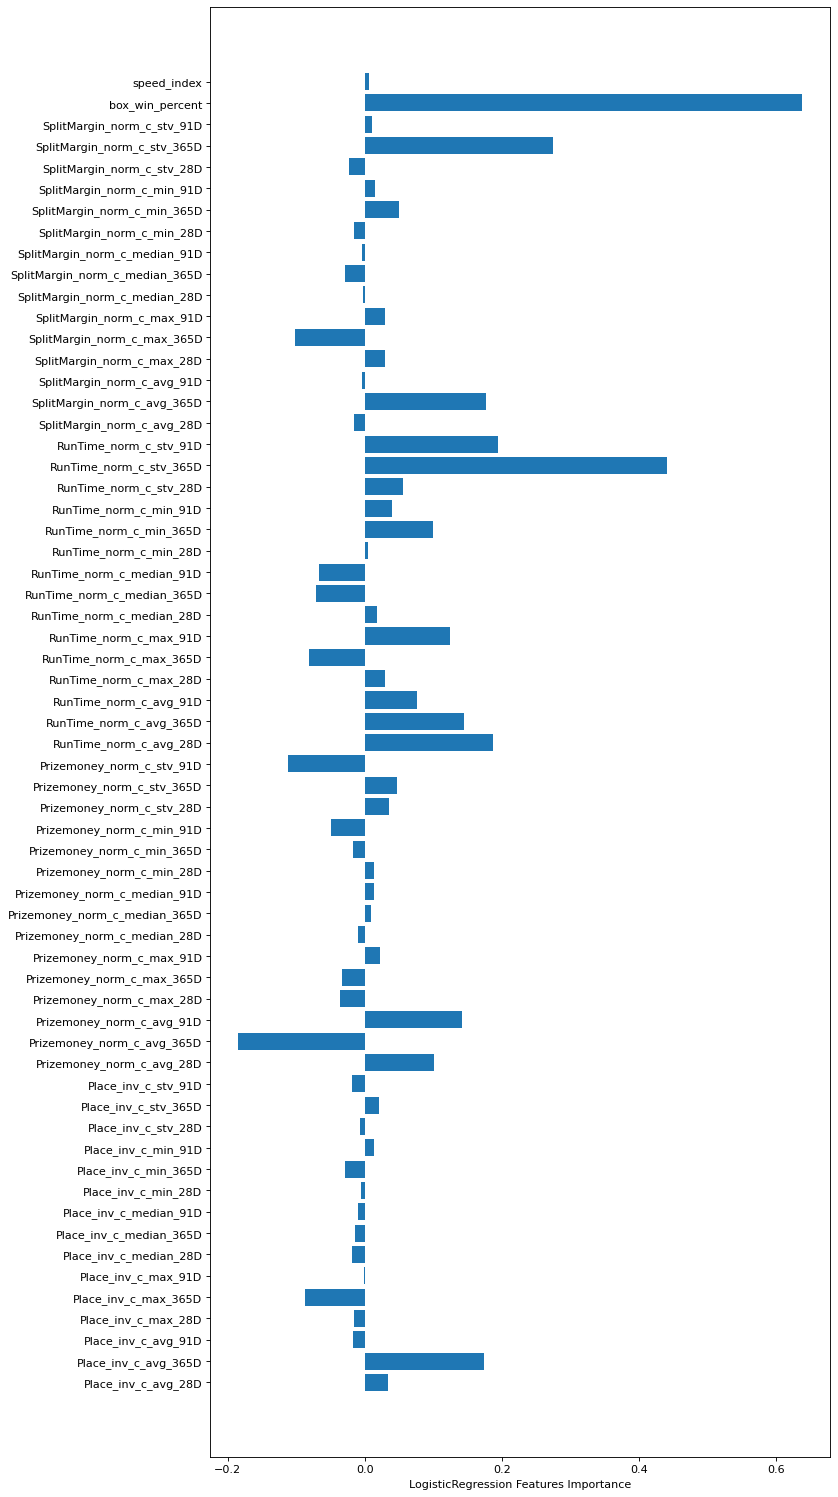

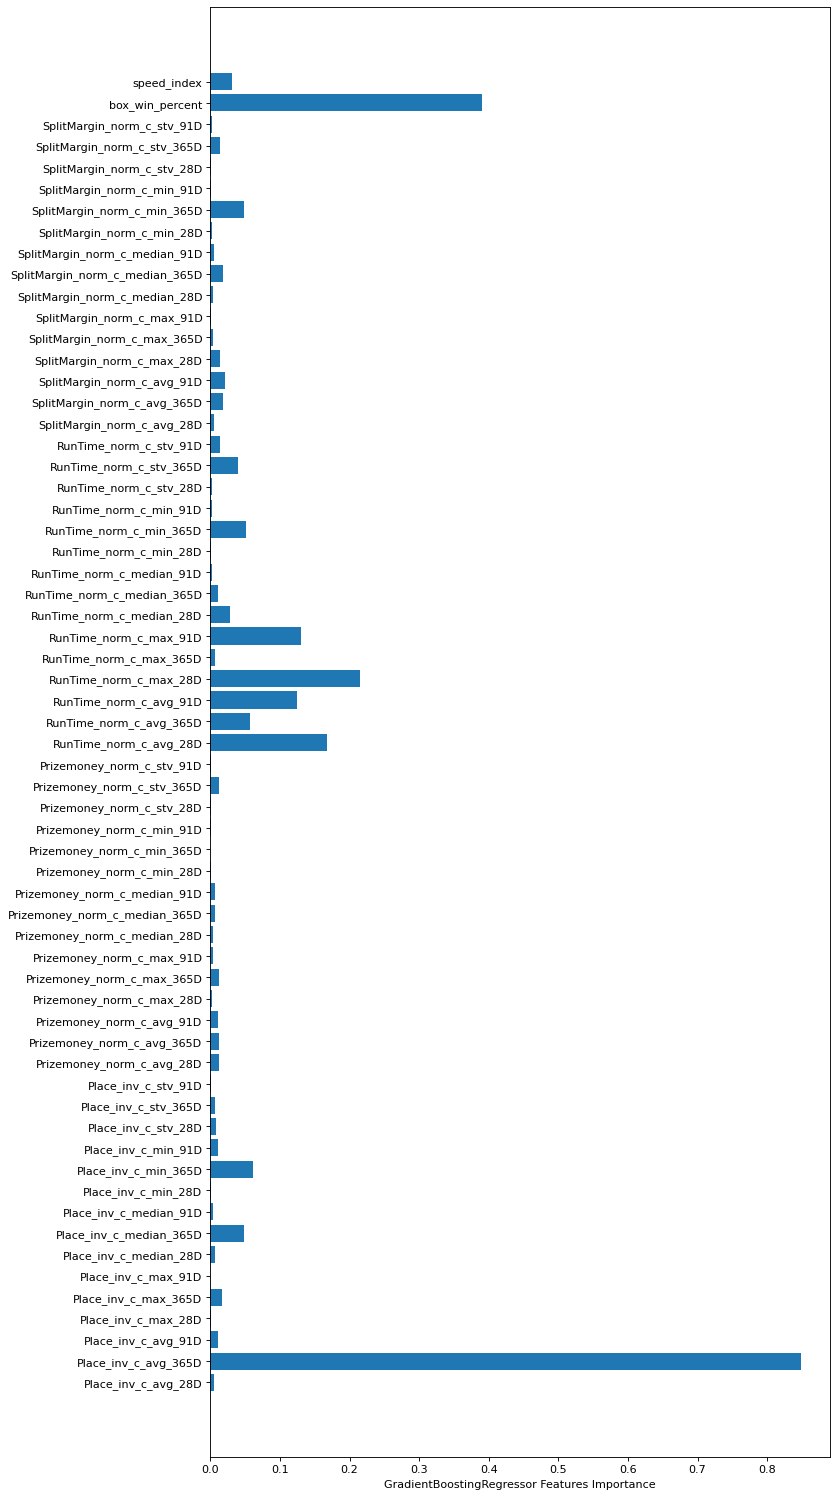

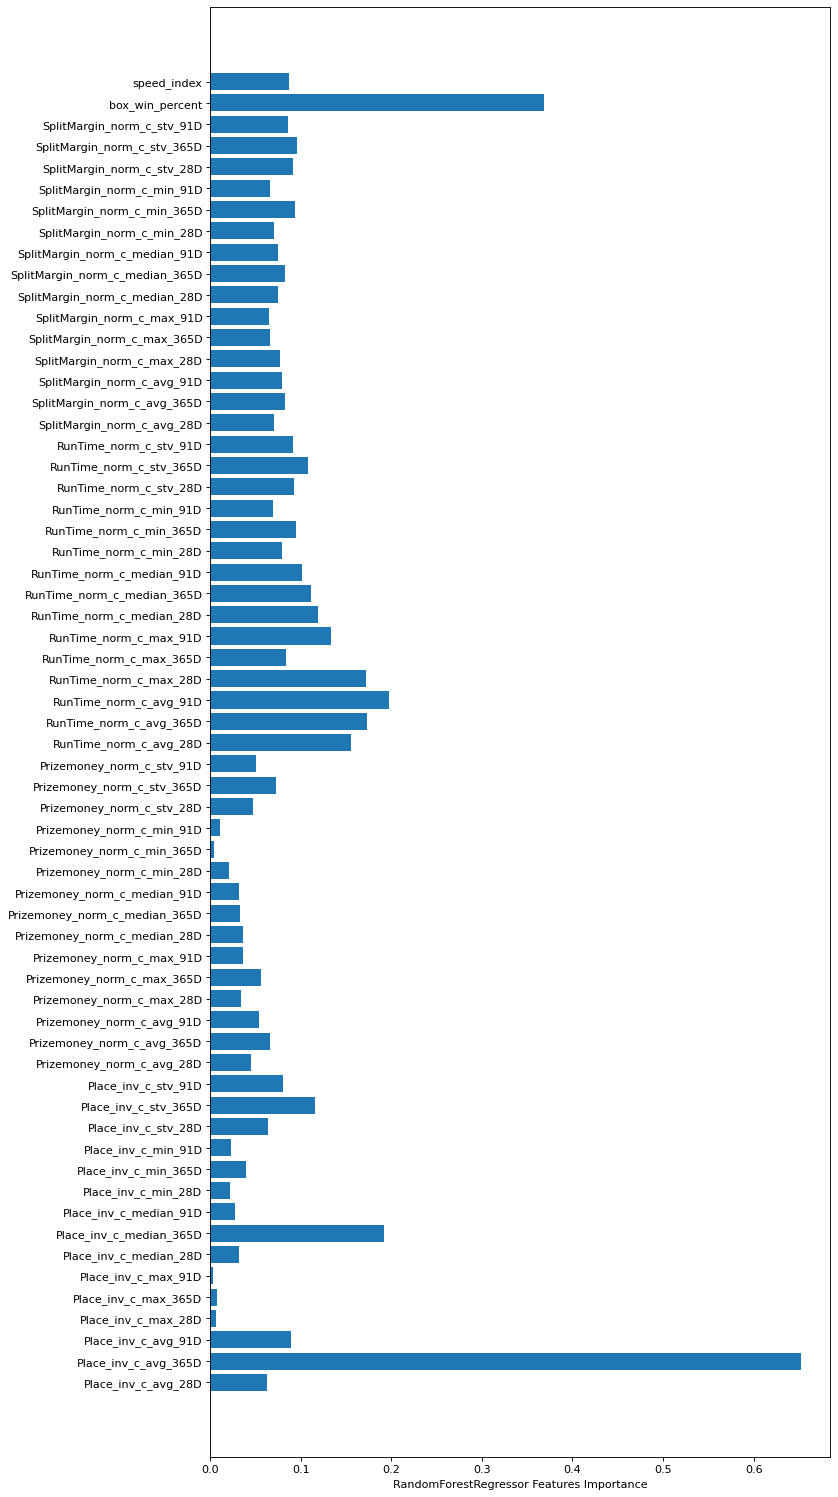

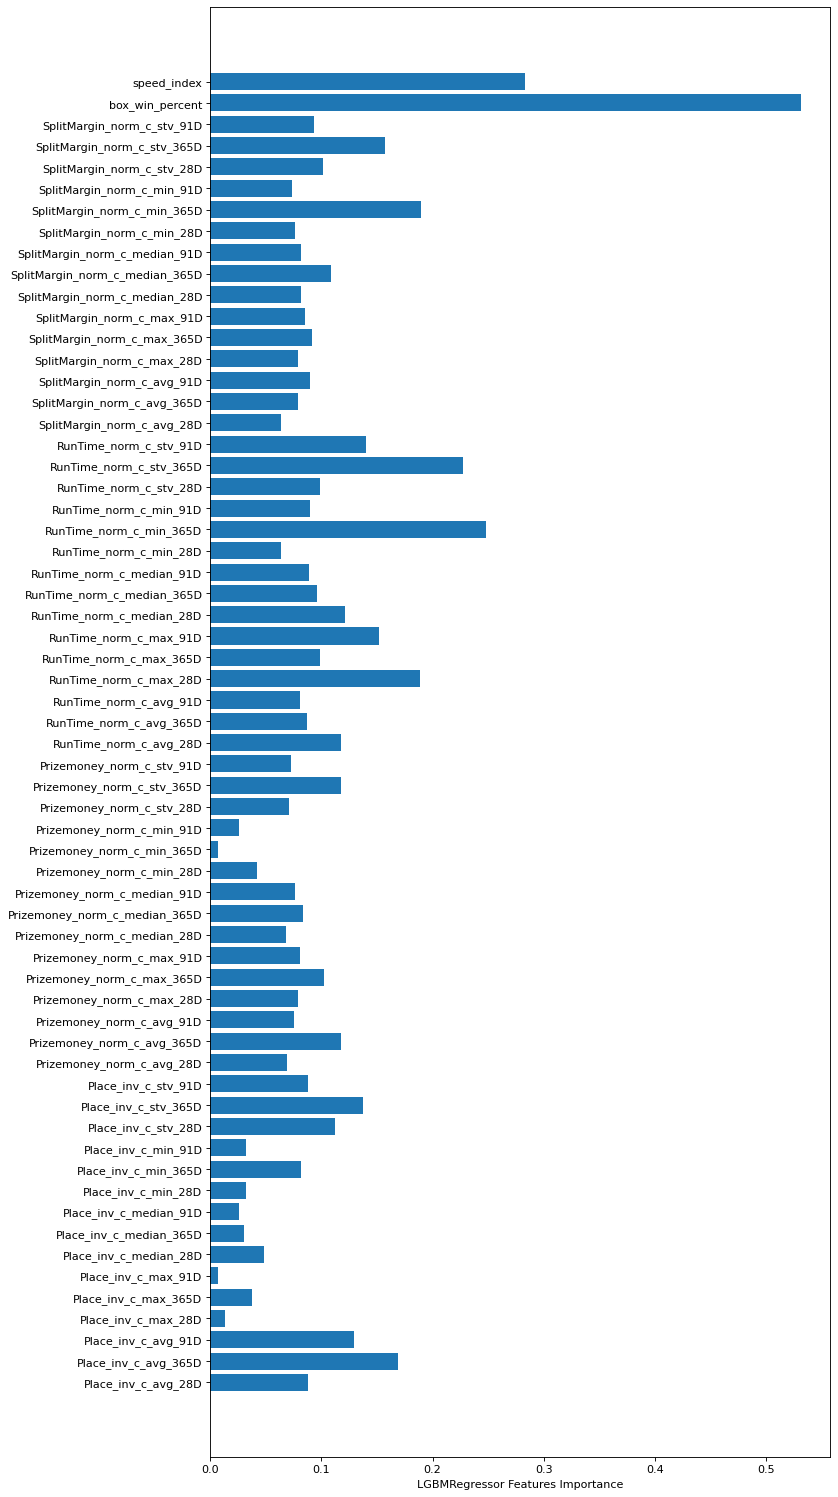

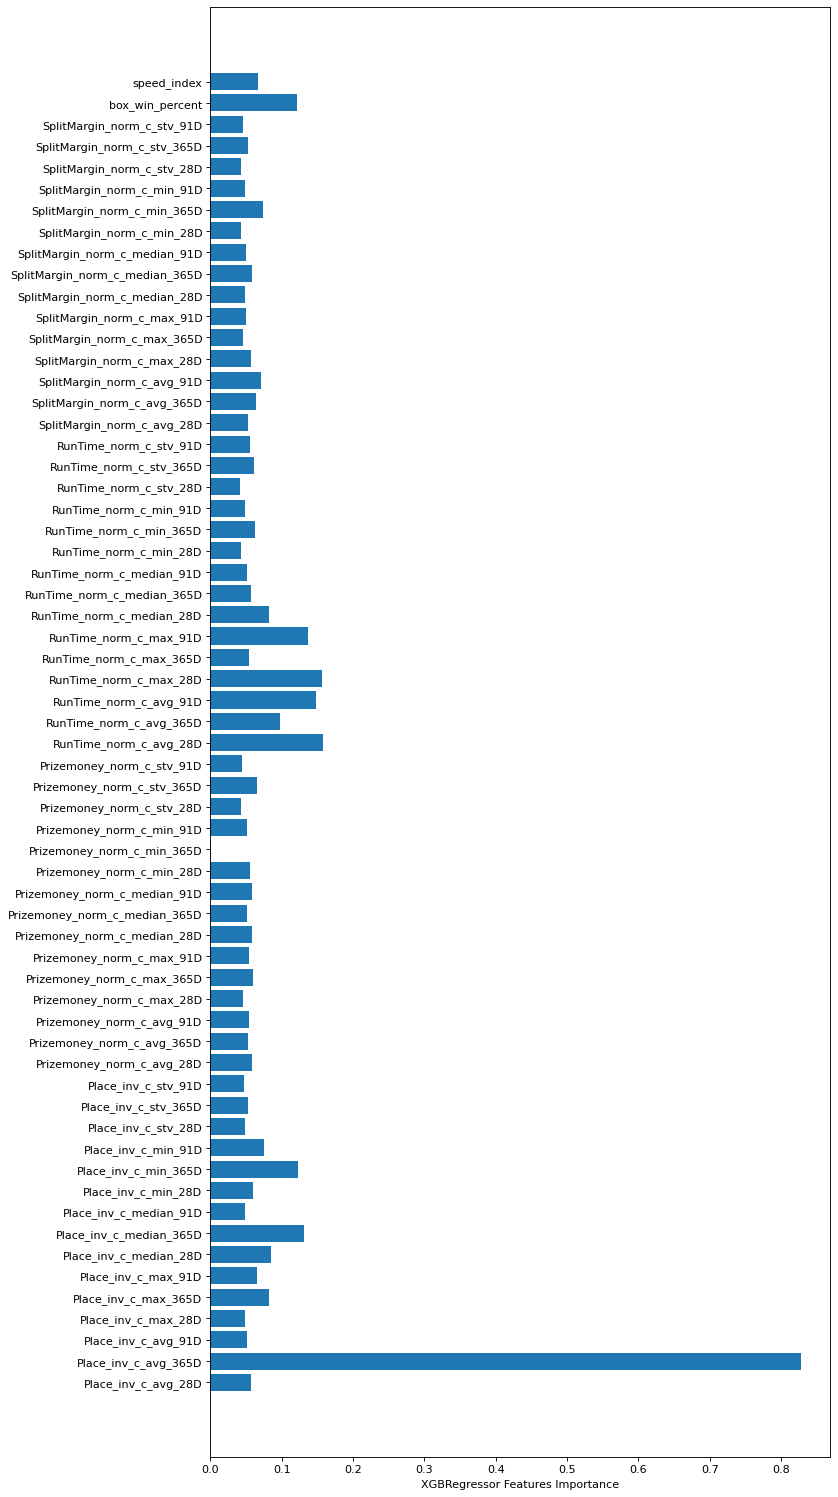

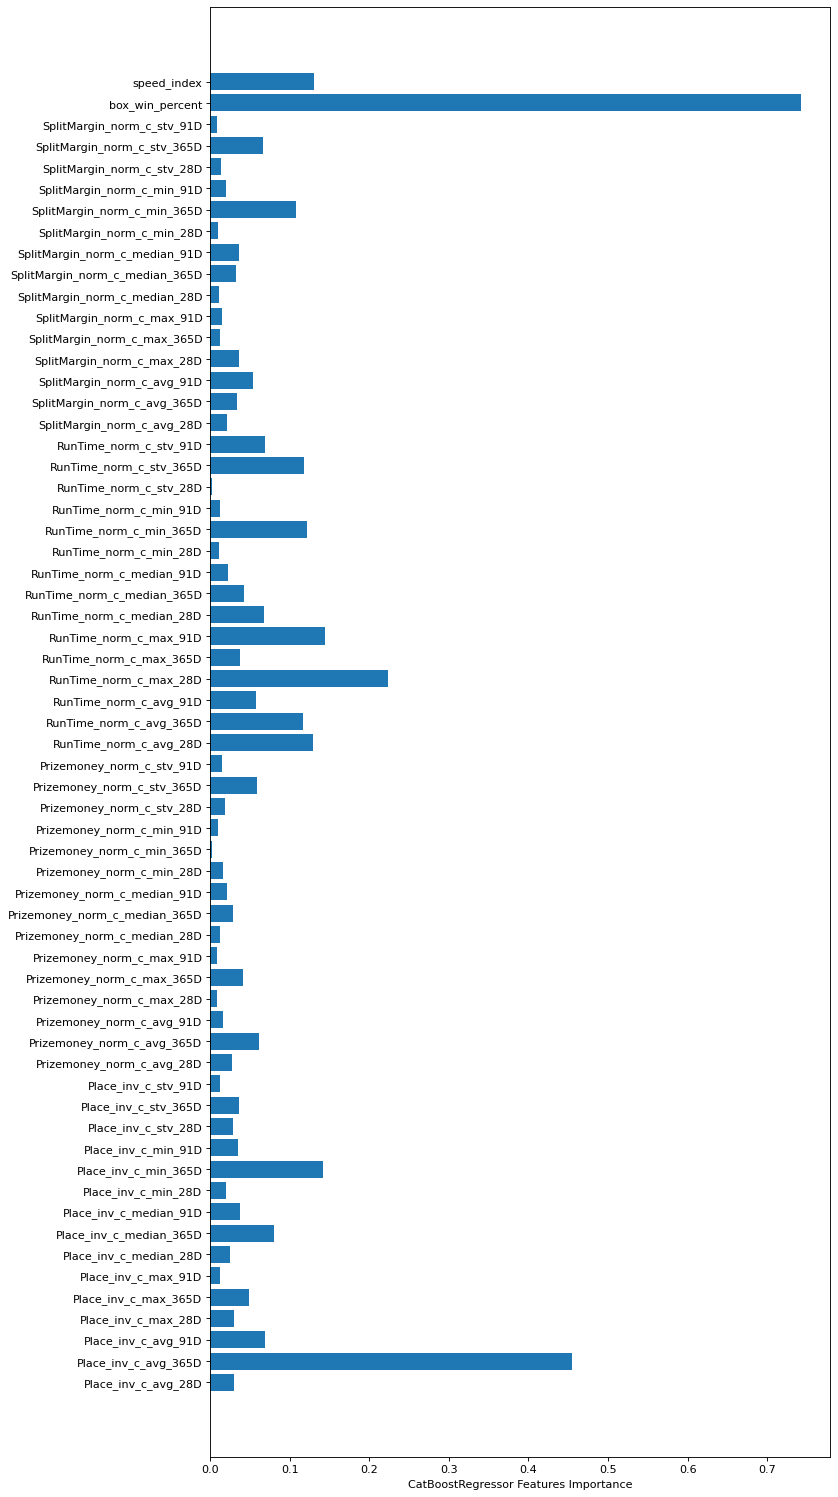

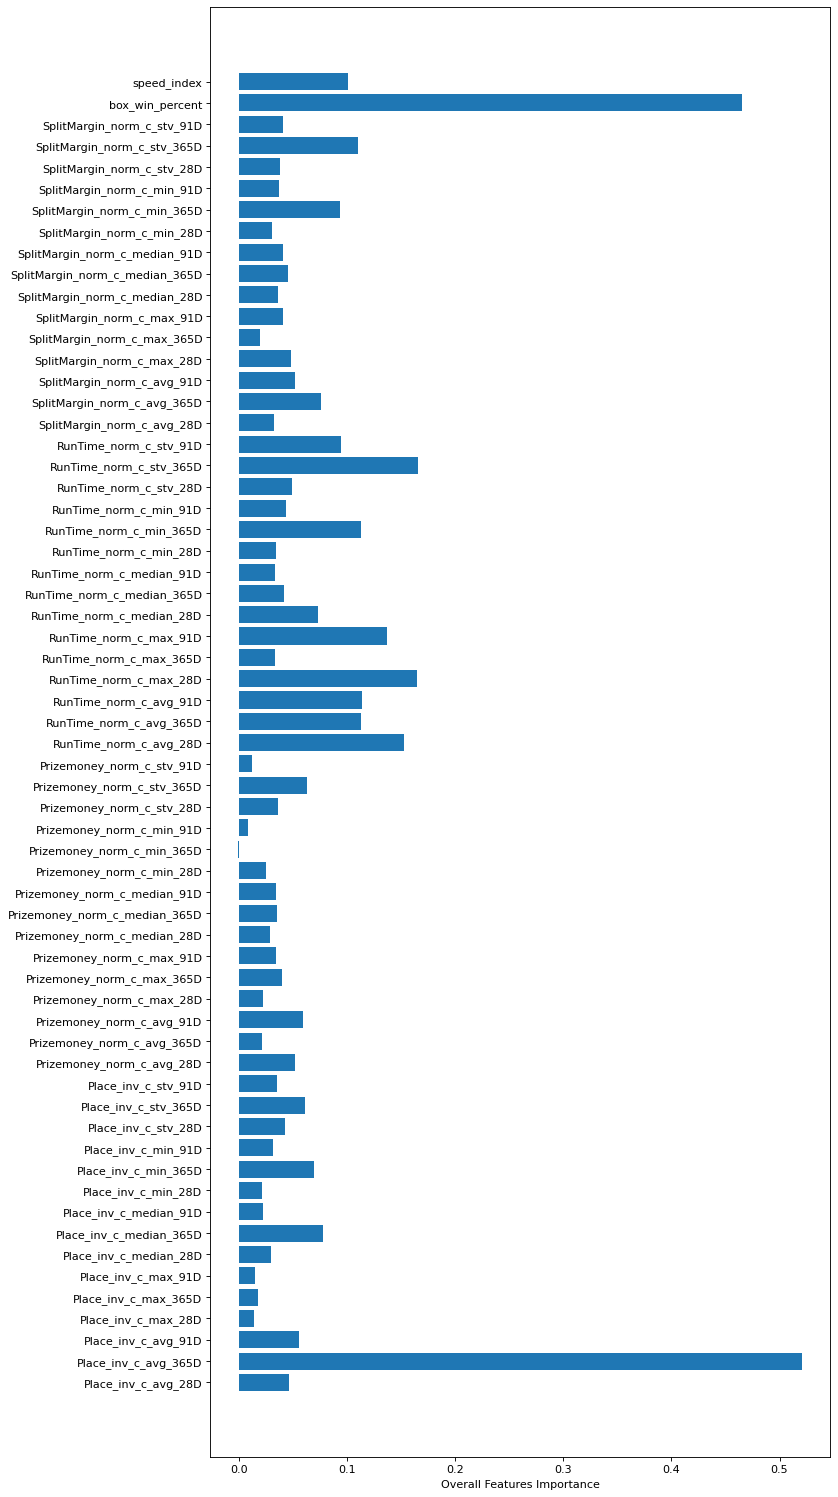

In [130]:
total_feature_importances = []

# Individual models feature importance
for key, model in models.items():
    figure(figsize=(10, 24), dpi=80)
    if isinstance(model, LogisticRegression):
        feature_importance = model.coef_[0]
    else:
        feature_importance = model.feature_importances_
    
    feature_importance = normalize(feature_importance[:,np.newaxis], axis=0).ravel()
    total_feature_importances.append(feature_importance)
    pyplot.barh(feature_cols, feature_importance)
    pyplot.xlabel(f'{key} Features Importance')
    pyplot.show()

# Overall feature importance
avg_feature_importances = np.asarray(total_feature_importances).mean(axis=0)
figure(figsize=(10, 24), dpi=80)
pyplot.barh(feature_cols, avg_feature_importances)
pyplot.xlabel('Overall Features Importance')
pyplot.show()

In [131]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Activation, Dropout, Input, Dense, Lambda, Masking, Reshape
import tensorflow.keras.backend as K
from tensorflow import keras

inputs = Input(shape=(train_x.shape[1],))
layer1 = Dense(1024, activation="relu")(inputs)
layer2 = Dense(1024, activation="tanh", kernel_initializer='glorot_uniform')(layer1)
layer3 = Dense(1024, activation="linear")(layer2)
outputs = Dense(1, activation="sigmoid")(layer3)
model = Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adamax()
loss      = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001, from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy', 'binary_crossentropy'])
model.summary()

model.fit(x=train_x, y=train_y, validation_data=(test_x, test_y), epochs=10)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              64512     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1025      
Total params: 2,164,737
Trainable params: 2,164,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6726/6726 [==============================] - 21s 3ms/step - loss: 0.3923 - categorical_accuracy: 1.0000 

In [134]:
test_data['prob_Tensorflow'] = model.predict(test_x)
test_data['prob_Tensorflow'] = test_data.groupby('FastTrack_RaceId')['prob_Tensorflow'].apply(lambda x: x / sum(x))
predicted_winners = test_data.groupby('FastTrack_RaceId')['prob_Tensorflow'].apply(lambda x: x == max(x))
print('Model {} predicts the winner in {:.2%} of races'.format('Tensorflow',
    len(test_data[(predicted_winners == True) & (test_data['win'] == 1)]) / test_data['FastTrack_RaceId'].nunique()
    ))

Model Tensorflow predicts the winner in 33.69% of races


In [135]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(test_data.head(16))

,date_dt,FastTrack_RaceId,DogName,win,StartPrice_probability,Place_inv_c_avg_28D,Place_inv_c_avg_365D,Place_inv_c_avg_91D,Place_inv_c_max_28D,Place_inv_c_max_365D,Place_inv_c_max_91D,Place_inv_c_median_28D,Place_inv_c_median_365D,Place_inv_c_median_91D,Place_inv_c_min_28D,Place_inv_c_min_365D,Place_inv_c_min_91D,Place_inv_c_stv_28D,Place_inv_c_stv_365D,Place_inv_c_stv_91D,Prizemoney_norm_c_avg_28D,Prizemoney_norm_c_avg_365D,Prizemoney_norm_c_avg_91D,Prizemoney_norm_c_max_28D,Prizemoney_norm_c_max_365D,Prizemoney_norm_c_max_91D,Prizemoney_norm_c_median_28D,Prizemoney_norm_c_median_365D,Prizemoney_norm_c_median_91D,Prizemoney_norm_c_min_28D,Prizemoney_norm_c_min_365D,Prizemoney_norm_c_min_91D,Prizemoney_norm_c_stv_28D,Prizemoney_norm_c_stv_365D,Prizemoney_norm_c_stv_91D,RunTime_norm_c_avg_28D,RunTime_norm_c_avg_365D,RunTime_norm_c_avg_91D,RunTime_norm_c_max_28D,RunTime_norm_c_max_365D,RunTime_norm_c_max_91D,RunTime_norm_c_median_28D,RunTime_norm_c_median_365D,RunTime_norm_c_median_91D,RunTime_norm_c_min_28D,RunTime_norm_c_min_365D,RunTime_norm_c_min_91D,RunTime_norm_c_stv_28D,RunTime_norm_c_stv_365D,RunTime_norm_c_stv_91D,SplitMargin_norm_c_avg_28D,SplitMargin_norm_c_avg_365D,SplitMargin_norm_c_avg_91D,SplitMargin_norm_c_max_28D,SplitMargin_norm_c_max_365D,SplitMargin_norm_c_max_91D,SplitMargin_norm_c_median_28D,SplitMargin_norm_c_median_365D,SplitMargin_norm_c_median_91D,SplitMargin_norm_c_min_28D,SplitMargin_norm_c_min_365D,SplitMargin_norm_c_min_91D,SplitMargin_norm_c_stv_28D,SplitMargin_norm_c_stv_365D,SplitMargin_norm_c_stv_91D,box_win_percent,speed_index,prob_LogisticRegression,prob_GradientBoostingRegressor,prob_RandomForestRegressor,prob_LGBMRegressor,prob_XGBRegressor,prob_CatBoostRegressor,odds_win_prediction,prob_Tensorflow
0,2021-02-28,643552772,SIMPLY GIFTED,0,0.015554,0.185238,0.221980,0.210823,0.250000,1.0,0.500000,0.166667,0.166667,0.166667,0.142857,0.125000,0.142857,0.041527,0.156535,0.102858,2.845950e-02,0.042340,0.045463,0.142298,0.238161,0.212109,0.000000,0.0,0.000000,0.0,0.0,0.0,6.363738e-02,7.757340e-02,7.982905e-02,0.459471,0.479724,0.475701,0.549353,0.670507,0.549353,0.463074,0.467312,0.467312,0.391424,0.355517,0.375271,0.058930,0.064110,0.059964,0.288346,0.394362,0.354314,0.368446,0.715903,0.499755,0.262626,0.368900,0.358447,0.233522,0.185941,0.233522,0.053621,0.106342,0.084488,0.108209,0.613697,0.059822,0.051556,0.053143,0.058699,0.039381,0.034826,False,0.038080
1,2021-03-18,650115206,SIMPLY GIFTED,0,0.033548,0.158730,0.213363,0.183598,0.166667,1.0,0.250000,0.166667,0.166667,0.166667,0.142857,0.125000,0.142857,0.013746,0.152334,0.041161,5.551115e-17,0.038235,0.031998,0.000000,0.238161,0.145682,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,7.391391e-02,6.349923e-02,0.403776,0.470664,0.444314,0.478591,0.670507,0.549353,0.397945,0.467312,0.463074,0.334792,0.334792,0.334792,0.072077,0.067604,0.063699,0.263012,0.376806,0.286765,0.336746,0.715903,0.368446,0.283136,0.358974,0.283136,0.169154,0.169154,0.169154,0.085589,0.109888,0.063118,0.191825,0.264684,0.120100,0.157755,0.112721,0.135367,0.107892,0.163181,False,0.082735
2,2021-02-14,640627712,DESTINI TRUCKER,0,0.018404,0.306667,0.349386,0.389394,0.500000,1.0,1.000000,0.250000,0.250000,0.333333,0.200000,0.125000,0.125000,0.118204,0.227726,0.252875,0.000000e+00,0.006998,0.000000,0.000000,0.216929,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.317089e-09,3.896154e-02,1.862645e-09,0.616346,0.581607,0.617011,0.655549,0.722815,0.722815,0.631899,0.595884,0.631899,0.534216,0.375577,0.479358,0.047473,0.070498,0.067987,0.615775,0.608431,0.632043,0.666667,0.768061,0.768061,0.629423,0.629423,0.629423,0.557632,0.280566,0.452107,0.043653,0.102228,0.098574,0.170910,0.354875,0.109477,0.104931,0.098666,0.098049,0.089673,0.100718,False,0.095087
3,2021-02-21,643136707,DESTINI TRUCKER,1,0.052499,0.240000,0.343676,0.359091,0.333333,1.0,1.000000,0.250000,0.250000,0.250000,0.166667,0.125000,0.125000,0.063026,0.226340,0.258211,0.000000e+00,0.006779,0.000000,0.000000,0.216929,0.000000